In [1]:
import nbsetup
import pymc3 as pm
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt

In [2]:
from models.sparc.dataframe import load_analysis

In [3]:
full_data = load_analysis()

In [4]:
filter_bad_simulation = full_data.query("Vbul==0.0").query("rel_R>0.1").query("rel_R<0.9")
filter_bad_quality = filter_bad_simulation.query("Q<3").query("Inc<80").query("Inc>30")


In [15]:
df = filter_bad_simulation
df = df.join(pd.DataFrame({'ID': coords['galaxy'], 'gidx': np.arange(len(coords['galaxy']))}).set_index('ID'), on='ID')

In [16]:
coords = {
    "galaxy": df.ID.unique(),
    "observation": df.Vobs.index
}


with pm.Model(coords=coords) as universe_model:
    
    # Universal priors
    gamma = pm.Uniform('gamma', 0, 50)
    alpha = pm.Uniform('alpha', 0, 0.5)
    epsilon = pm.Uniform('epsilon', -20, 20)
    sigma = pm.HalfCauchy("sigma", beta=5) # observational error

    # Data
    force = pm.Data("force", df.Fnewton, dims="observation")
    radius = pm.Data("radius", df.R, dims="observation")
    nulled = pm.Data("nulled", df.Fnulled, dims="observation")
    
    # Prediction model
    ftd = force*(gamma/(1+(epsilon*nulled)**alpha)) # adjust for nulled field
    vtd = np.sqrt(ftd*radius)
    
    # Define likelihood
    obs = pm.Normal("obs", mu=vtd, sigma=sigma, observed=df.Vobs, dims="observation")

In [17]:
with universe_model:
    uni_trace = pm.sample(tune=1000, draws=500, cores=8, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, epsilon, alpha, gamma]


Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 44 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.738796824575268, but should be close to 0.9. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7634694063356

In [18]:
az.summary(uni_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,28.954,2.726,24.413,34.162,0.199,0.141,182.0,145.0,1.04
alpha,0.254,0.005,0.243,0.263,0.000,0.000,410.0,738.0,1.03
epsilon,11.060,4.517,5.136,19.946,0.359,0.254,139.0,118.0,1.06
sigma,24.203,0.411,23.409,24.922,0.015,0.010,770.0,533.0,1.02


array([<AxesSubplot:title={'center':'gamma'}>,
       <AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'epsilon'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

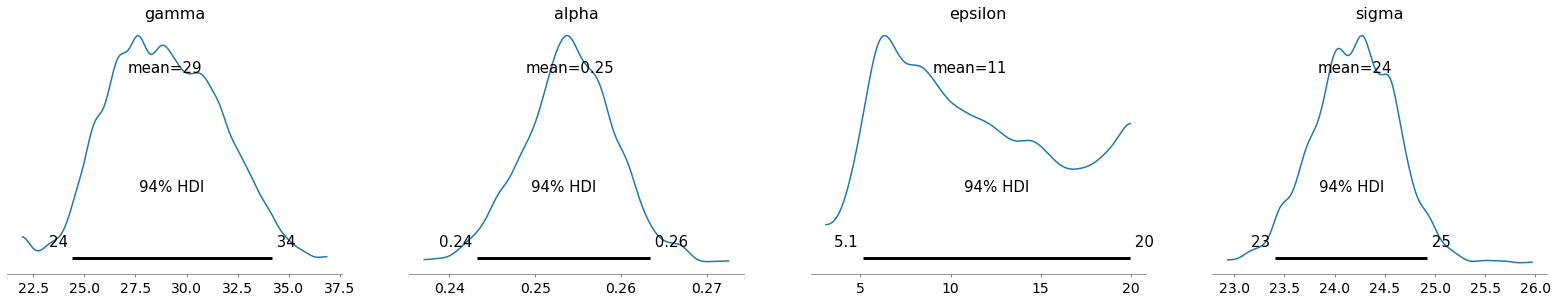

In [19]:
az.plot_posterior(uni_trace)

In [23]:
coords = {
    "galaxy": df.ID.unique(),
    "observation": df.Vobs.index
}

sparc = {}
for var in ('Inc', 'e_Inc', 'D', 'e_D'):
    sparc[var] = df.groupby('ID')[var].mean()

    
with pm.Model(coords=coords) as galaxy_model:
    
    # Universal priors
    gamma = pm.Uniform('gamma', 0, 100)
    alpha = pm.Uniform('alpha', 0, 1)
    
    # Error
    sigma = pm.HalfCauchy("sigma", beta=5, dims="observation")
    
    # Galaxy priors
    DegreesNormal = pm.Bound(pm.Normal, lower=0.0, upper=90.0)
    inc = DegreesNormal('Inc', mu=sparc['Inc'], sigma=sparc['e_Inc'], dims='galaxy')
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    dist = PositiveNormal('D', mu=sparc['D'], sigma=sparc['e_D'], dims='galaxy')
    #tau = pm.Exponential('tau field', 1)

    # Data
    force = pm.Data("force", df.Fnewton, dims="observation")
    radius = pm.Data("radius", df.R, dims="observation")
    nulled = pm.Data("nulled", df.Fnulled, dims="observation")
    sparc_d = pm.Data("sparc_distance", df.D, dims="observation")
    sparc_inc = pm.Data("sparc_inc", df.Inc, dims="observation")
    g = pm.Data("g", df.gidx, dims="observation")
    
    # Prediction model
    ftd = force*(gamma/(1+(nulled)**alpha)) # adjust for nulled field
    vtd = np.sqrt(ftd*radius*dist[g]/sparc_d[g]) # adjust r for distance when calc V
    vpred = vtd*np.sin(inc[g]*np.pi/180)/np.sin(sparc_inc[g]*np.pi/180) # adjust for inclination of Vobs
    
    # Define likelihood
    obs = pm.Normal("obs", mu=vpred, sigma=sigma, observed=df.Vobs, dims="observation")

In [24]:
with galaxy_model:
    gal_trace = pm.sample(tune=1000, draws=500, cores=4, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [distance, inclination, alpha, gamma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [27]:
az.summary(gal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,49.978,0.022,49.937,50.000,0.000,0.000,2454.0,992.0,1.00
alpha,0.198,0.001,0.196,0.201,0.000,0.000,812.0,963.0,1.00
inclination[CamB],27.611,3.350,21.554,33.997,0.074,0.055,2191.0,1329.0,1.00
inclination[DDO064],58.331,4.938,48.858,67.054,0.107,0.076,2152.0,1620.0,1.00
inclination[DDO154],49.586,2.608,44.475,54.188,0.053,0.038,2457.0,1667.0,1.00
...,...,...,...,...,...,...,...,...,...
distance[UGC12632],26.330,1.559,23.451,29.265,0.029,0.021,2825.0,1765.0,1.00
distance[UGC12732],30.218,2.088,26.239,33.910,0.049,0.034,1803.0,1492.0,1.00
distance[UGCA281],5.803,0.271,5.329,6.366,0.004,0.003,4663.0,1346.0,1.00
distance[UGCA442],5.040,0.207,4.658,5.416,0.003,0.002,4703.0,1357.0,1.01


In [54]:
mc_d = np.array(gal_trace.posterior['inclination']).mean(axis=0).mean(axis=0)

In [55]:
mc_d

array([27.61117986, 58.33121332, 49.58551357, 66.41135375, 30.8928444 ,
       64.13882518, 78.75159059, 73.77118564, 45.64078018, 82.72100071,
        6.48771712, 20.91663099, 42.99605639, 16.14479837, 28.41316163,
        8.4873534 , 13.38119198,  9.85810395, 13.48813191, 83.46491406,
        7.8405424 ,  7.73468779,  3.65849273,  7.3860531 , 61.63913907,
       13.3715205 , 33.697554  , 57.39610748, 45.04120824, 77.61563394,
       88.71753868, 66.57361354, 42.51535279, 84.85744118, 80.00570168,
       65.94533245, 63.71612073, 55.01053287, 59.67216947, 57.37278663,
       65.60792623, 77.16794354, 39.55516903, 57.84866679, 85.05861031,
       71.41843822, 74.40833536, 52.37732567, 76.65357659, 69.7060342 ,
       75.98016933, 48.45124237, 78.94175735, 54.7000305 , 61.9209441 ,
       76.98033945, 55.37982111, 88.72101172, 48.0365779 , 45.85371665,
       81.90608291, 68.69827879, 72.66075448, 81.79128322, 83.23502788,
       47.20013168, 66.94137669, 43.43375575, 52.73389694, 52.70

In [61]:
sparc['ID'] = coords['galaxy']
for label, prior in ('D', 'distance'),('Inc', 'inclination'):
    sparc['%s_pred' % label] = np.array(gal_trace.posterior[prior]).mean(axis=0).mean(axis=0)


In [62]:
pd.DataFrame(sparc)

,Inc,e_Inc,D,e_D,ID,D_pred,Inc_pred
ID,,,,,,,
CamB,65.0,5.0,3.36,0.26,CamB,2.791123,27.611180
DDO064,60.0,5.0,6.80,2.04,DDO064,1.532657,58.331213
DDO154,64.0,3.0,4.04,0.20,DDO154,3.399913,49.585514
DDO161,70.0,10.0,7.50,2.25,DDO161,0.958587,66.411354
DDO168,63.0,6.0,4.25,0.21,DDO168,4.066185,30.892844
...,...,...,...,...,...,...,...
UGC12632,46.0,3.0,9.77,2.93,UGC12632,26.330302,56.561342
UGC12732,39.0,6.0,13.20,4.00,UGC12732,30.217944,61.300263
UGCA281,67.0,3.0,5.68,0.28,UGCA281,5.803240,68.228311
